## Detecting Real or Fake Disaster Tweets
Author: Sandi Besen 
<br /> 6/12/2020
<br /> Using Kaggle competition data https://www.kaggle.com/c/nlp-getting-started/data


## Load Libraries and Setup





Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fastai library and metrics

In [7]:
from fastai.vision import *
from fastai.metrics import error_rate
from urllib import *

In [8]:
import numpy as np
import pandas as pd

In [9]:
import warnings; warnings.simplefilter('ignore')

In [10]:
from torch.utils.data import *

In [11]:
from fastai.text import *

## Download Data

Mount Google Drive so we can download the data

In [12]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


change the current working directory to the Classification folder

In [13]:
%cd /content/gdrive/My Drive/NLP

/content/gdrive/My Drive/NLP


check the current working directory for confirmation that we are working in the correct folder

In [14]:
%pwd

'/content/gdrive/My Drive/NLP'

Extract the Zip File and then write out the folders to the wordking directory

In [ ]:
## extracting zip file
import zipfile

def main():

    # assigning filename to a variable
    file_name = 'nlp-getting-started.zip'

    # opening Zip using 'with' keyword in read mode
    with zipfile.ZipFile(file_name, 'r') as file:
        # printing all the information of archive file contents using 'printdir' method
        print(file.printdir())

        # extracting the files using 'extracall' method
        print('Extracting all files...')
        file.extractall()
        print('Done!') # check your directory of zip file to see the extracted files

if __name__ == '__main__': main()

File Name                                             Modified             Size
sample_submission.csv                          2019-12-16 20:36:22        22746
test.csv                                       2019-12-16 20:36:22       420783
train.csv                                      2019-12-16 20:36:22       987712
None
Extracting all files...
Done!


set path for use in fastai library

In [15]:
path = '/content/gdrive/My Drive/NLP/'

## Data Discovery


In [16]:
train_data = pd.read_csv('train.csv')
display(train_data)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
print("There are" , np.sum(train_data['target']==1) , "True Tweets" )
print("There are" , np.sum(train_data['target']!=1), "False Tweets")

There are 3271 True Tweets
There are 4342 False Tweets


In [ ]:
test_data = pd.read_csv('test.csv')
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_data['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [ ]:
train_data['text'][600]

'#BreakingNews http://t.co/gAN14PW9TG FedEx no longer willing to transport research specimens of potential bioter\x89Û_ http://t.co/5n4hUsewLy'

##Data Processing

Create a TextDataBunch. This does the data pre-processing that allows us to use text. Unlike images, we can not simply feed them into the neural net. We must tokenize them (break them down into parts of words) and numericalize them (assign each work to an associated number). This TextDataBunch does this for us. We will take a look at what it has done in subsequent sections.

In [17]:
data_lm = TextDataBunch.from_csv(path, 'train.csv', valid_pct = .2, test = 'test.csv',text_cols = 3, label_cols = 4)

In [18]:
data_lm.save()

In [19]:
data = load_data(path)

## Show Tokenization

We need to split the words in the sentence, accounting for punctuation, contractions, and other nuances. This is what a tokenized sentence looks like.


In [15]:
data_lm.show_batch()

text,target
xxbos _ \n xxrep 5 ? xxup retweet \n xxrep 7 ? \n xxrep 5 ? xxup follow xxup all xxup who xxup rt \n xxrep 7 ? \n xxrep 5 ? xxup followback \n xxrep 7 ? \n xxrep 5 ? xxup gain xxup with \n xxrep 7 ? \n xxrep 5 ? xxup follow ? xxunk # xxup xxunk,0
xxbos xxup info xxup u. xxup cld : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 . xxup wnd : 030 / 6 .,0
xxbos xxup info xxup s. xxup wnd : 030 / 6 . xxup cld : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 .,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,0
xxbos xxmaj no # news of # hostages in # xxmaj libya \n \n http : / / t.co / xxunk \n \n # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1


## Show Numericalization

Numericalization converts the tokenized text to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

Here are the first 10 tokens in our dataset that have occured at least twice.

In [16]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '/']

Here is what the dataset actually looks like. Notice that it is numericalized. Each of these numbers corresponds to a vocab word in our dictionary.

In [17]:
data_lm.train_ds[0][0]

Text [   2    5   14    5 1462    5  100    5  284   26   79   17  737   15    5  557 1636  276   25   13 1823   13 1637
   12   10    9    9   11    9    0]

In [ ]:
data_lm.train_ds[0][0].data[:10]

array([  2,   0, 209,  14, 609, 395,  64,  36, 230,   5])

##Classifier Model

In [31]:
bs = 64

In [21]:
labels = [1, 0]

In [29]:
data_clas = (TextDataBunch.from_csv(path, 'train.csv', valid_pct = .2, test = 'test.csv',text_cols = 3, label_cols = 4)
            )

data_clas.save('data_clas.pkl')

In [32]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [33]:
data_clas.show_batch()

text,target
xxbos _ \n xxrep 5 ? xxup retweet \n xxrep 7 ? \n xxrep 5 ? xxup follow xxup all xxup who xxup rt \n xxrep 7 ? \n xxrep 5 ? xxup xxunk \n xxrep 7 ? \n xxrep 5 ? xxup gain xxup with \n xxrep 7 ? \n xxrep 5 ? xxup follow ? xxunk # xxup xxunk,0
xxbos . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n \n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0
xxbos xxup info xxup u. xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup xxunk xxup xxunk . xxup xxunk 05 . xxup curfew xxup in xxup xxunk xxup until xxunk xxup xxunk xxup xxunk xxup foxtrot 5 & & xxup foxtrot 6 xxup xxunk . xxup xxunk : 10 . xxup xxunk : xxunk / 6 .,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,0


In [34]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)


In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


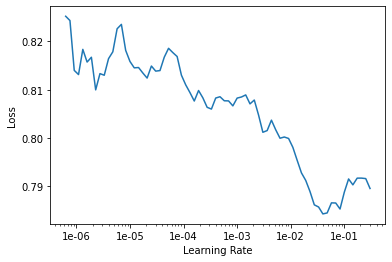

In [36]:
learn.recorder.plot(skip_end=15)

In [37]:
learn.fit_one_cycle(8, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.728522,0.700613,0.475378,02:28
1,0.692833,0.677779,0.569928,02:34
2,0.683933,0.667257,0.591596,02:34
3,0.675028,0.653992,0.594222,02:29
4,0.673215,0.653561,0.593565,02:37
5,0.667487,0.648911,0.608011,02:30
6,0.666522,0.647678,0.624425,02:42
7,0.667465,0.650478,0.620486,02:38


In [38]:
learn.save('first')

In [39]:
learn.load('first');

In [40]:
learn.unfreeze()

In [41]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.561179,0.495093,0.786605,06:45


In [42]:
learn.save('second')

In [44]:
learn.load('second');

In [46]:
learn.unfreeze()

In [47]:
learn.fit_one_cycle(1,1e-3, moms=(0.8,.07))

epoch,train_loss,valid_loss,accuracy,time
0,0.455113,0.457112,0.802364,06:47


In [48]:
learn.save('third')

In [52]:
learn.load('third');

Next we would like to see what words of a specific tweet are give the most weight/ importace. The darker the purple, the more important the word is to predict an outcome. Below are the associated weights.

In [53]:
import matplotlib.cm as cm

txt_ci = TextClassificationInterpretation.from_learner(learn)

In [54]:
test_text = "Fire on I-95 off of Glades Road. Caution!"
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

In [55]:
txt_ci.intrinsic_attention(test_text)[1]

tensor([0.8621, 0.8985, 1.0000, 0.9730, 0.8668, 0.7562, 0.6730, 0.5382, 0.3991,
        0.3397, 0.3028, 0.2908, 0.2650, 0.2343, 0.2060, 0.1181])

Let's look at the top losses. These are the tweets the model struggled most with. 

In [56]:
txt_ci.show_top_losses(5)


Text,Prediction,Actual,Loss,Probability
xxbos hereûªs how media in xxmaj pakistan covered the capture of terrorist xxmaj xxunk xxmaj naved http : / / t.co / xxunk,1,0,3.26,0.04
xxbos all that panicking made me tired ; _ _ ; i want to sleep in my bed,0,1,3.05,0.05
xxbos xxmaj israel wrecked my home . xxmaj now it wants my land . \n https : / / t.co / xxunk,0,1,2.99,0.05
xxbos xxmaj governor xxunk parole for xxmaj california school bus hijacker http : / / t.co / xxunk http : / / t.co / xxunk,1,0,2.96,0.05
xxbos xxmaj today was trauma on top of trauma on top of trauma in xxmaj richmond so i know work is going to be crazy the next two days,1,0,2.83,0.06


Below, I made up my own tweet and predicted if it would be classified as real (1) or fake (0).

In [57]:
learn.predict("Fire on I-95 off of Glades Road. Caution!")

(Category tensor(1), tensor(1), tensor([0.2088, 0.7912]))